In [5]:
#Run this cell to attach libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(RColorBrewer)
library(themis)

In [4]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [17]:
#url <- "https://github.dev/jternier/Test/blob/main/data%5B1%5D.csv"

#download.file(url, "data/data2.csv")	

In [6]:
data <- read_delim(file = "data/data.csv", delim = ";") #Load the data into R. File is semi-colon separated so use read_delim function
head(data)

Rows: 4424 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr  (1): Target
dbl (36): Marital_status, Application_mode, Application_order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Marital_status,Application_mode,Application_order,Course,Daytime/evening attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mother_qualification,Father_qualification,⋯,Curricular_units_2nd_sem_(credited),Curricular_units_2nd_sem_(enrolled),Curricular_units_2nd_sem_(evaluations),Curricular_units_2nd_sem_(approved),Curricular_units_2nd_sem_(grade),Curricular_units_2nd_sem_(without evaluations),Unemployment_rate,Inflation_rate,GDP,Target
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,17,5,171,1,1,122.0,1,19,12,⋯,0,0,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,15,1,9254,1,1,160.0,1,1,3,⋯,0,6,6,6,13.66667,0,13.9,-0.3,0.79,Graduate
1,1,5,9070,1,1,122.0,1,37,37,⋯,0,6,0,0,0.00000,0,10.8,1.4,1.74,Dropout
1,17,2,9773,1,1,122.0,1,38,37,⋯,0,6,10,5,12.40000,0,9.4,-0.8,-3.12,Graduate
2,39,1,8014,0,1,100.0,1,37,38,⋯,0,6,6,6,13.00000,0,13.9,-0.3,0.79,Graduate
2,39,1,9991,0,19,133.1,1,37,37,⋯,0,5,17,5,11.50000,5,16.2,0.3,-0.92,Graduate


In [7]:
tidy_data <- data|>
select(Previous_qualification, Previous_qualification_grade, Admission_grade, Target, GDP, Inflation_rate, Unemployment_rate,) |> # select our columns of interest
filter(Previous_qualification == 1) |> #We only want to examine observations whose previous education is completed secondary education
filter(Target == "Graduate" | Target == "Dropout") |> #We only want to examine the binary of dropout vs graduate (not students currently enrolled)
mutate(Target = as_factor(Target)) #We want our classification variable to be a factor as there's a limited amount of categories
head(tidy_data)
nrow(tidy_data) #Check we still have a sufficient amount of observations that meet our criteria

Previous_qualification,Previous_qualification_grade,Admission_grade,Target,GDP,Inflation_rate,Unemployment_rate
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
1,122,127.3,Dropout,1.74,1.4,10.8
1,160,142.5,Graduate,0.79,-0.3,13.9
1,122,124.8,Dropout,1.74,1.4,10.8
1,122,119.6,Graduate,-3.12,-0.8,9.4
1,100,141.5,Graduate,0.79,-0.3,13.9
1,142,128.4,Graduate,-4.06,2.8,15.5


[1] 3019

In [8]:
#Split the data into training and testing. 75% for training and 25% for testing.
# Because we are classifying target, use that as strata
# Set seed so analysis is reproducible
set.seed(2004)

data_split <- initial_split(tidy_data, prop = 0.75, strata = Target) 
dropout_training <- training(data_split) #name training and testing data sets
dropout_testing <- testing(data_split)

__Graphing__

In [10]:
mean_admission_grade <- dropout_training |>
select(Target, Admission_grade) |>
group_by(Target) |>
summarize(grade = mean(Admission_grade))
mean_admission_grade

mean_qualification_grade <- dropout_training |>
select(Target, Previous_qualification_grade) |>
group_by(Target) |>
summarize(grade = mean(Previous_qualification_grade))
mean_qualification_grade

Target,grade
<fct>,<dbl>
Dropout,124.5490
Graduate,127.8052


Target,grade
<fct>,<dbl>
Dropout,130.7624
Graduate,133.7166


Target,count
<fct>,<int>
Dropout,808
Graduate,1455


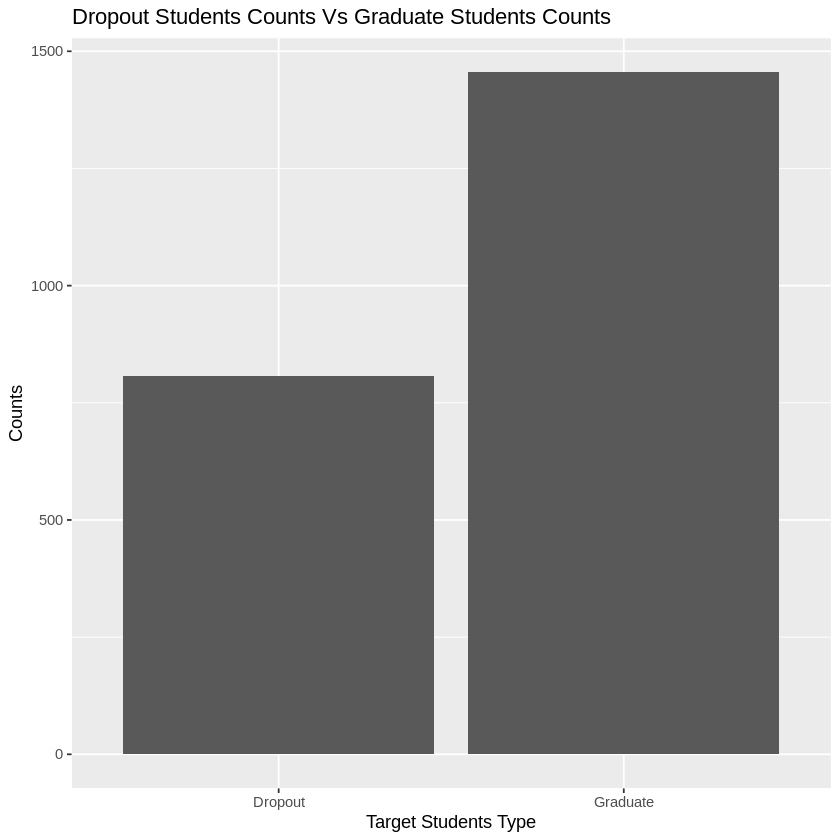

In [11]:
target_count_data <- dropout_training |>
group_by(Target) |>
summarise(count = n())
target_count_data

target_count_graph <- target_count_data |>
ggplot(aes(x = Target, y = count)) +
geom_bar(stat = "identity")+
labs(x = "Target Students Type", y = "Counts") +
ggtitle("Dropout Students Counts Vs Graduate Students Counts ")
target_count_graph 

The bar graph above, titled "Droppout Students Vs Graduate Students Counts" illustrates the split of the dataset between the number of students who dropped out and who graduated. Based on the graph, it is evident that there is a disproportionately high number of students who graduated from a higher secondary instituition. Therefore, when we are analysing our data, we may have to conduct oversampling to ensure that the numbers for students who graduated and students who dropped out are comparable. This will help ensure that the analysis is unbiased and the results are more reliable.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


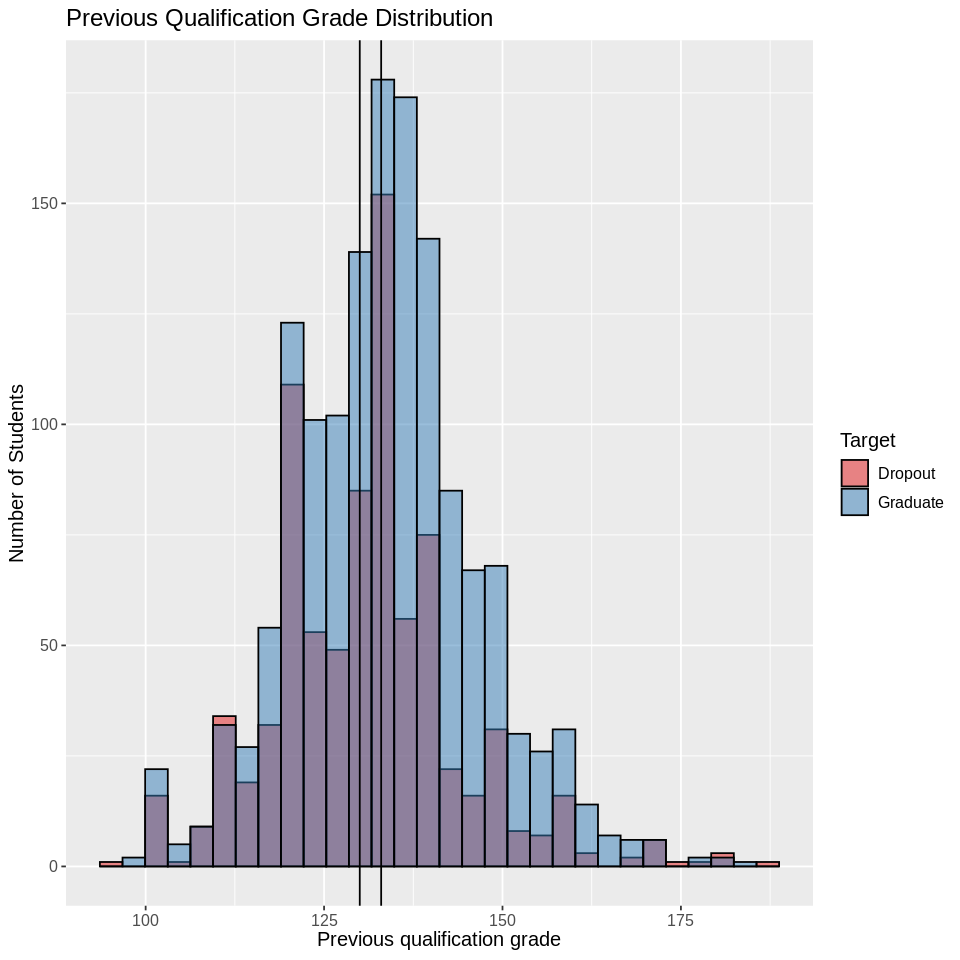

In [13]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
ggplot(aes(x = Previous_qualification_grade, fill = Target)) +
geom_histogram(color = 'black', alpha = 0.5, position = "identity") +
geom_vline(xintercept = 130 ) +
geom_vline(xintercept = 133 ) +
labs( x = "Previous qualification grade", y = "Number of Students", fill = "Target") +
scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 12))+
ggtitle("Previous Qualification Grade Distribution")
grade_plot

The histogram titled "Previous Qualification Grade Distribution" showcases the distribution of the previous grade acheieved by the high school student before they entered the higher education instituition. Furthemore, this graph helps us visualise the distribution and gives us an overview of the performance of the students we are analysing. The data is split into two colours that overlap each other and represent the two catergories of students that are drop out and graduate. It helps us directly compare the distribution of the two.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


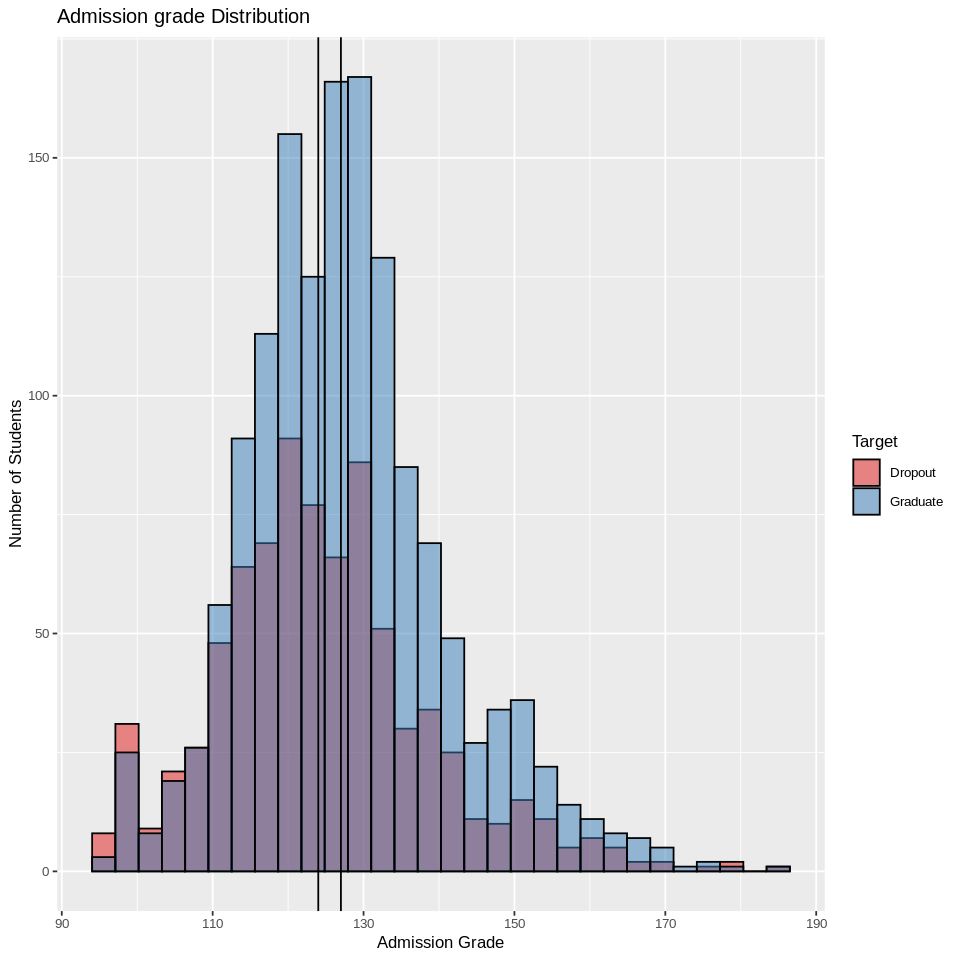

In [14]:
options(repr.plot.width = 8, repr.plot.height = 8)
grade_plot <- dropout_training |>
ggplot(aes(x = Admission_grade, fill = Target)) +
geom_histogram(color = 'Black', alpha = 0.5, position = "identity") +
geom_vline(xintercept = 124) +
geom_vline(xintercept = 127) +
labs( x = "Admission Grade", y = "Number of Students", fill = "Target") + 
scale_fill_brewer(palette = 'Set1') +
theme(text = element_text(size = 10)) +
ggtitle("Admission grade Distribution")
grade_plot

The histogram titled "Admission Grade Distribtution" serves a similar purpose to that earlier graph, except it visualises the distribution of the average admission grade and the number of students who selected schools with that speicific admission grade. Once again, the students are split into dropout and graduated catergories by colours to differentiate and compare their admission grade distributions.

The two histograms aid in illustrating the distributions of the two predictor variables we plan to use for our classification analysis to answer the research question. It works as a guideline to ensure that our analysis isn't unbiased and that our results are reliable.

__GDP/Target Student__

GDP,Target
<dbl>,<fct>
1.74,Dropout
1.74,Dropout
-4.06,Dropout
⋮,⋮
-4.06,Graduate
-3.12,Graduate
-1.70,Graduate


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


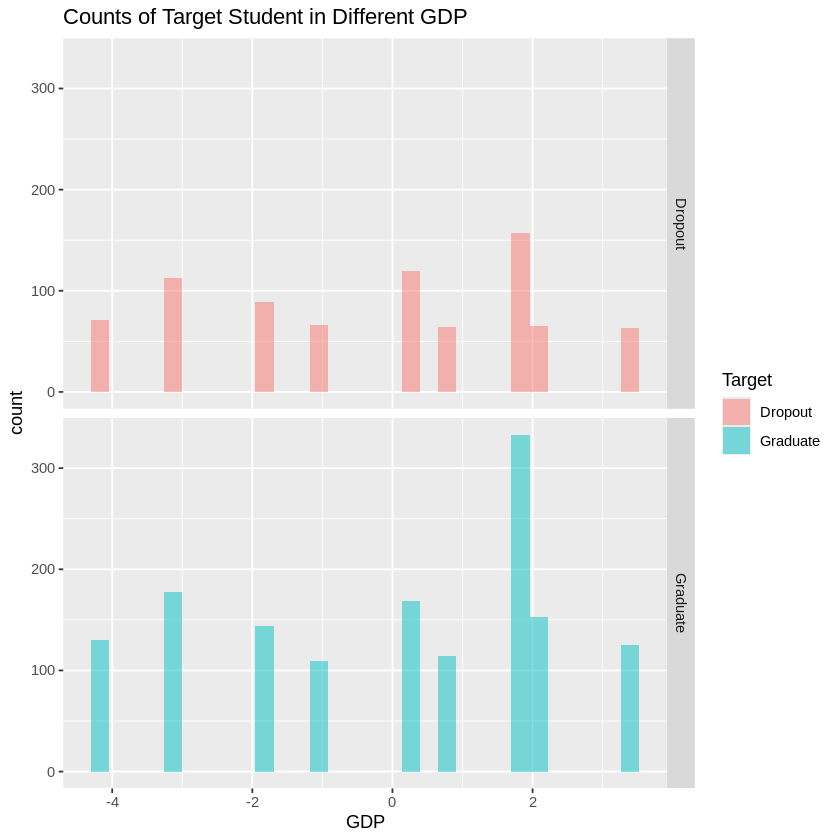

In [16]:
target_econ_data <- dropout_training |>
select(GDP,Target) |>
group_by(Target)
target_econ_data

options(repr.plot.width = 7, repr.plot.height = 7)
econ1_plot <- target_econ_data |>
ggplot(aes(x = GDP, fill = Target)) +
geom_histogram(alpha = 0.5) +
labs(x = 'GDP', y = 'count', fill = 'Target', title = 'Counts of Target Student in Different GDP') +
facet_grid(rows = vars(Target)) 
econ1_plot

__Inflation/Target Student__

Inflation_rate,Target
<dbl>,<fct>
1.4,Dropout
1.4,Dropout
2.8,Dropout
⋮,⋮
2.8,Graduate
-0.8,Graduate
3.7,Graduate


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


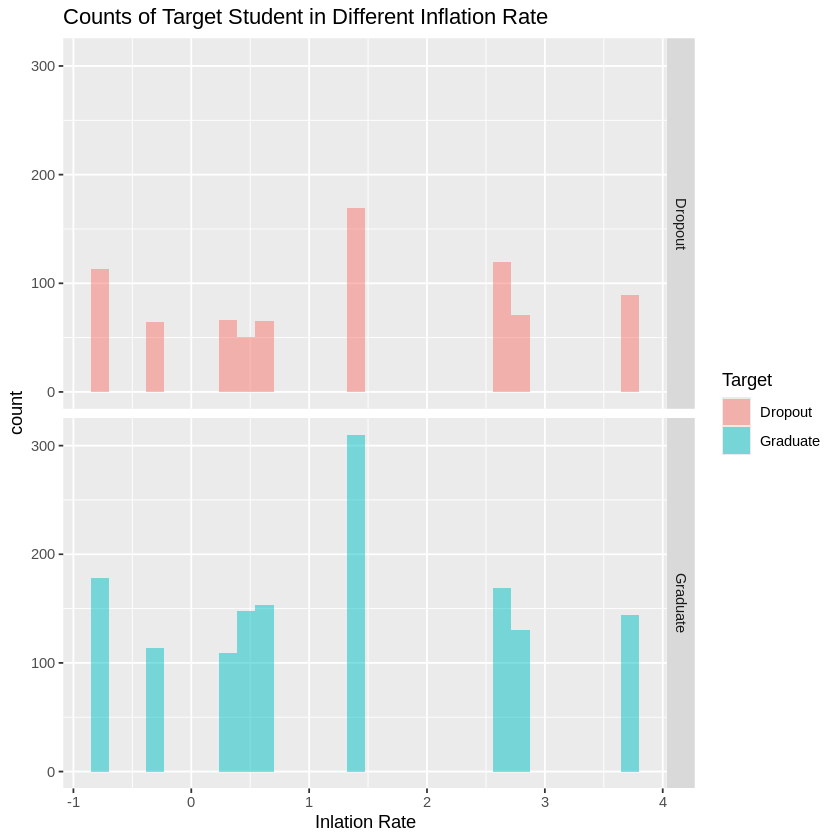

In [19]:
target_inflation_data <- dropout_training |>
select(Inflation_rate, Target) |>
group_by(Target)
target_inflation_data

inflation_plot <- target_inflation_data |>
ggplot(aes(x =Inflation_rate, fill = Target)) +
geom_histogram(alpha = 0.5) +
labs(x = 'Inlation Rate', y = 'count', fill = 'Target', title = 'Counts of Target Student in Different Inflation Rate') +
facet_grid(rows = vars(Target)) 
inflation_plot

__Unemployment/Target Student__

Unemployment_rate,Admission_grade,Target
<dbl>,<dbl>,<fct>
10.8,127.3,Dropout
10.8,124.8,Dropout
15.5,113.1,Dropout
⋮,⋮,⋮
15.5,122.2,Graduate
9.4,153.8,Graduate
12.7,152.0,Graduate


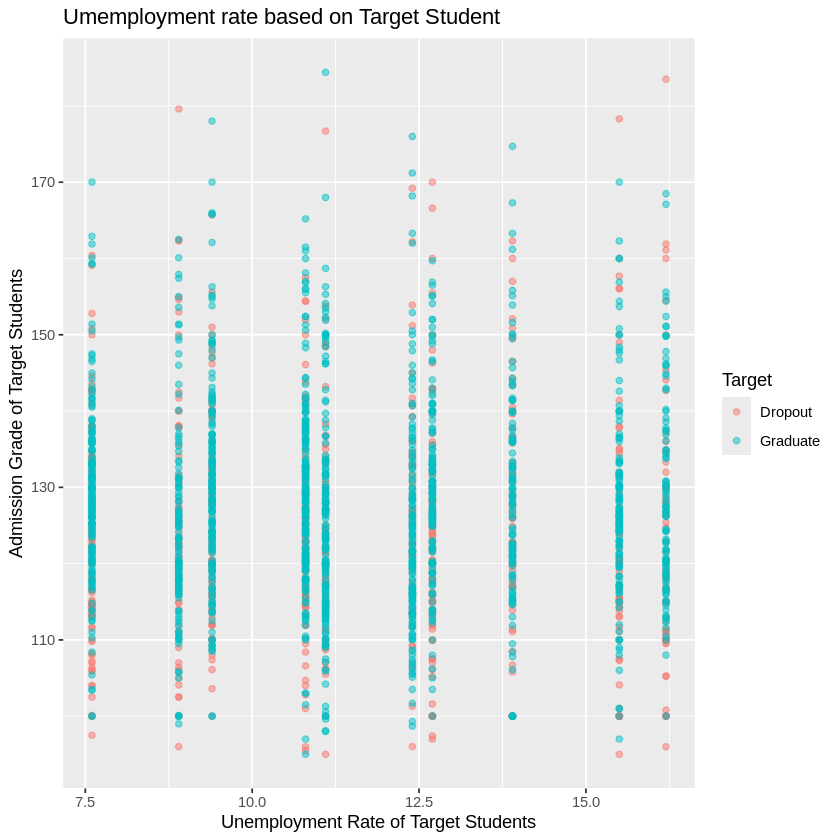

In [21]:
target_Unemployment_data <- dropout_training |>
select(Unemployment_rate, Admission_grade, Target) |>
group_by(Target)
target_Unemployment_data

Unemployment_plot <- target_Unemployment_data |>
ggplot(aes(x = Unemployment_rate, y = Admission_grade, colour = Target)) +
geom_point(alpha = 0.5) +
labs(x = 'Unemployment Rate of Target Students', y = 'Admission Grade of Target Students', fill = 'Target', title = 'Umemployment rate based on Target Student')
Unemployment_plot



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 2263 data points and no incomplete rows.



── Operations 

• Up-sampling based on: Target | Trained

• Scaling for: Previous_qualification_grade, Admission_grade | Trained

• Centering for: Previous_qualification_grade, Admission_grade | Trained



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5704881,8,0.006816880,Preprocessor1_Model01
2,accuracy,binary,0.5713668,8,0.008348535,Preprocessor1_Model02
3,accuracy,binary,0.5377728,8,0.004596729,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,binary,0.5567736,8,0.01098587,Preprocessor1_Model08
9,accuracy,binary,0.5616432,8,0.01240502,Preprocessor1_Model09
10,accuracy,binary,0.5598765,8,0.01203610,Preprocessor1_Model10


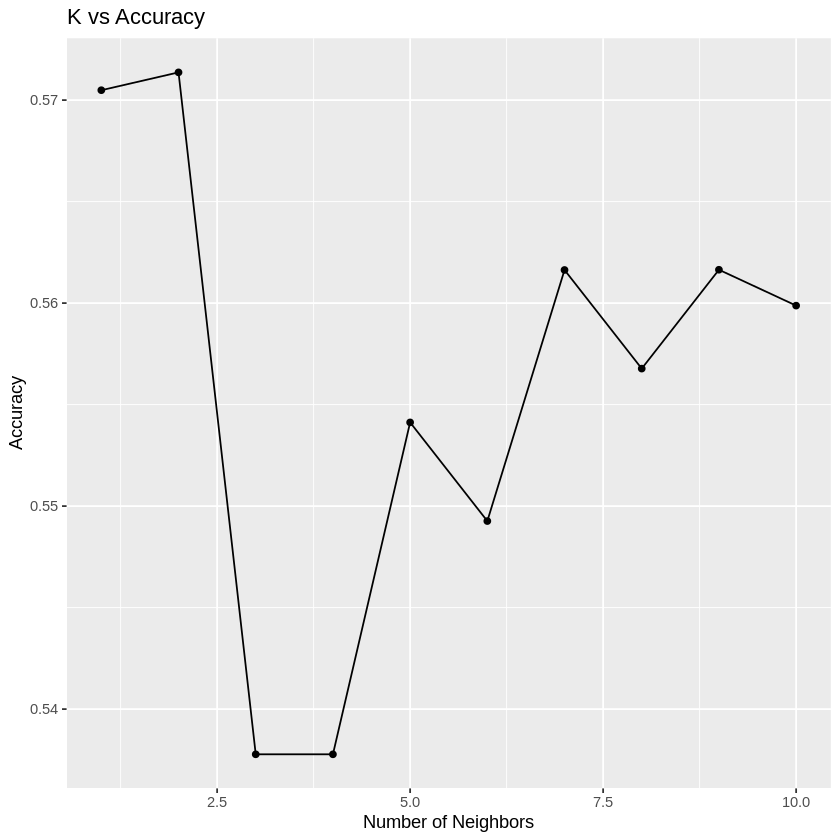

In [18]:
set.seed(2000)

# Create Recipe
dropout_recipe <- recipe(Target ~ Previous_qualification_grade + Admission_grade, data = dropout_training) |>
step_upsample(Target, over_ratio = 1, skip = TRUE) |>
step_scale(all_predictors()) |>
step_center(all_predictors()) |>
prep()

dropout_recipe

#Specify folds for cross validation
dropout_vfold <- vfold_cv(dropout_training, v = 8, strata = Target)

#Specify K-values to try
gridvals <- tibble("neighbors" = seq(from = 1, to = 10, by = 1))

#Add specification
dropout_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
set_engine("kknn") |>
set_mode("classification")

dropout_workflow <- workflow() |>
add_recipe(dropout_recipe) |>
add_model(dropout_spec) |>
tune_grid(resamples = dropout_vfold, grid = gridvals) |>
collect_metrics() |>
filter(.metric == "accuracy")

dropout_workflow

cross_val_plot <- dropout_workflow |>
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
xlab("Number of Neighbors") + 
ylab("Accuracy") +
ggtitle("K vs Accuracy")

cross_val_plot

In [ ]:
cross_val_plot <- dropout_workflow |>
ggplot(aes(x = neighbors, y = mean)) + 
geom_point() +
geom_line() + 
xlab("Number of Neighbors") + 
ylab("Accuracy") +
ggtitle("K vs Accuracy")

cross_val_plot